# Análisis de sentimientos de la guerra de Rusia y Ucrania

Autor: Alejandro Jerónimo Fuentes

## Introducción y problema a resolver

Si algo se caracteriza el año 2022 es por el estallido de la guerra entre Rusia y Ucrania. Desde que empezó el conflicto se han vertido ríos de tinta en noticias y redes, dejando de lado por un tiempo otros problemas que han afectado a la humanidad en los últimos años, como la pandemia de COVID-19.

Esta situación ha generado un montón de datos disponibles en Internet, como imágenes, vídeos y opiniones en redes sociales. Un ejemplo de esto sería la red social Twitter, donde el conflicto ha sido tendencia durante más de un mes. La cantidad de opiniones generada es muy grande, por lo que es necesario analizarla para entender mejor lo que está ocurriendo. Por ello, el objetivo de este trabajo consiste en hacer un análisis de sentimientos sobre dichas opiniones, usando redes neuronales artificiales.

Para llevar a cabo el objetivo principal, definimos los siguientes objetivos secundarios:

1. Análisis de los tweets en inglés, debido a que los tweets en este idioma son los más numerosos.
2. Análisis de los tweets en español, dado que nos interesa saber la importancia del conflicto en países de habla hispana.
3. Creación de varios modelos de redes neuronales artificiales: redes feedforward, LSTM y arquitecturas del estado del arte.

## Descripción de los datos

Los datos que vamos a usar están extraídos usando la API de Twitter desde que comenzó el conflicto. La monitorización de los tweets es continua; la base de datos se actualiza cada día entre la 1 y las 3 de la madrugada UTC. Tenemos un total 23.6 millones de tweets en varios idiomas.

Las columnas de la base de datos contienen los siguientes campos:

- **userid**: identificador del usuario
- **username**: nombre de usuario en Twitter
- **acctdesc**: descripción que tiene el usuario en su cuenta
- **location**: localización del usuario a la hora de enviar el tweet.
- **following**: números de usuarios que sigue el usuario que ha escrito el tweet.
- **followers**: número de seguidores que tiene el autor del tweet.
- **totaltweets**: el número total de tweets que ha realizado el usuario desde que creó la cuenta.
- **usercreatedts**: indica la fecha de creación de la cuenta de usuario.
- **tweetid**: identificador del tweet.
- **tweetcreatedts**: indica la fecha de creación del tweet.
- **retweetcount**: número de retweets que tiene el tweet escrito.
- **text**: el texto del tweet.
- **hashtags**: indican los hashtags que están presentes en el tweet.
- **language**: idioma del tweet.
- **coordinates**: coordenadas precisas de la localización del tweet.
- **favorite_count**: indica el número de likes (o favoritos) del tweet.
- **extractedts**: fecha de extracción del tweet mediante la API de Twitter.

En total tenemos 17 columnas. En este trabajo se van a tener en cuenta solo los primeros 6000 tweets de cada día desde que comenzó el registro. Concretamente, desde el 27 de febrero hasta el 17 de abril. En total tendremos unos 300.000 tweets. Este filtrado lo hacemos debido a que existen más de 400.000 tweet por día. Esta cantidad es muy grande para Pandas, por lo que se necesitarían otras herramientas para trabajar con grandes cantidades de datos.


In [1]:
# Importamos en primer lugar los paquetes necesarios
import os

# Módulo de expresiones regulares
import re

# Librerías de visualización
import matplotlib.pyplot as plt

# Librerías de NLTK
import nltk
import numpy as np
import pandas as pd
import swifter
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

nltk.download("stopwords")
from html import unescape

# Para eliminar caracteres de escape
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# Librerías de pysentimiento
from pysentimiento import create_analyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajf97\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Análisis exploratorio

El primer paso a la hora de hacer nuestro análisis consiste en saber qué datos tenemos y cómo son nuestros datos para poder tomar decisiones. En primer lugar, vamos a realizar la carga de los datos. Estos se encuentran en formato _gzip_ por cada una de las ejecuciones de la API. Vamos a cargar solamente las primeras 6000 filas de cada archivo.


In [5]:
# Vamos a cargar en una lista todos los nombres de los archivos que están en la carpeta data
files_path = []

for dirname, _, filenames in os.walk("data"):
    for filename in filenames:
        files_path.append(os.path.join(dirname, filename))


# Lectura de los datos. Concatenamos todos los datos en un solo dataframe
data_list = []

for file in files_path:
    data = pd.read_csv(file, compression="gzip", index_col=0, nrows=6000)
    data_list.append(data)

df = pd.concat(data_list, axis=0)

In [6]:
# Observamos la dimensionalidad de los datos
df.shape

(300000, 17)

In [7]:
# Observamos las columnas que tenemos
data.columns

Index(['userid', 'username', 'acctdesc', 'location', 'following', 'followers',
       'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts',
       'retweetcount', 'text', 'hashtags', 'language', 'coordinates',
       'favorite_count', 'extractedts'],
      dtype='object')

In [8]:
# Vemos los tipos de datos que tenemos
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          6000 non-null   int64 
 1   username        6000 non-null   object
 2   acctdesc        4896 non-null   object
 3   location        3473 non-null   object
 4   following       6000 non-null   int64 
 5   followers       6000 non-null   int64 
 6   totaltweets     6000 non-null   int64 
 7   usercreatedts   6000 non-null   object
 8   tweetid         6000 non-null   int64 
 9   tweetcreatedts  6000 non-null   object
 10  retweetcount    6000 non-null   int64 
 11  text            6000 non-null   object
 12  hashtags        6000 non-null   object
 13  language        6000 non-null   object
 14  coordinates     1 non-null      object
 15  favorite_count  6000 non-null   int64 
 16  extractedts     6000 non-null   object
dtypes: int64(7), object(10)
memory usage: 843.8+ KB


In [9]:
# Vemos el aspecto que tienen los primeros datos
data.head()

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts
0,310044382,Barrie360,What Barrie's talking about. From local news t...,"Barrie, Ontario",678,16818,106996,2011-06-03 03:17:10.000000,1509319562654720000,2022-03-31 00:00:00.000000,0,"Humanitarian drive in Midhurst sends medicine,...","[{'text': 'Ukraine', 'indices': [63, 71]}]",en,NaN,0,2022-03-31 00:09:25.807372
1,1414872724292337667,silpantipolo,This is the official Twitter account of San Is...,Diocese of Antipolo,9,14,398,2021-07-13 09:03:02.000000,1509319562658865155,2022-03-31 00:00:00.000000,0,"This morning, #LetUsPray for #RussiaUkraine th...","[{'text': 'LetUsPray', 'indices': [14, 24]}, {...",en,NaN,0,2022-03-31 01:12:01.286851
2,19897138,IndiaToday,"Brings you news breaks: Exclusive political, e...",India,245,6008572,1005019,2009-02-02 07:21:54.000000,1509319563095142401,2022-03-31 00:00:00.000000,2,#RussiaUkraineWar | Horrors of nuclear war hau...,"[{'text': 'RussiaUkraineWar', 'indices': [0, 1...",en,NaN,2,2022-03-31 01:12:01.269963
3,3632161,omyword,Collage Artist; Long ago writer at Wonkette be...,"Bisbee, AZ",4966,2659,267294,2007-04-06 16:04:09.000000,1509319563237740544,2022-03-31 00:00:00.000000,5,Moral support. #Ukraine https://t.co/wcysaBFdkE,"[{'text': 'Ukraine', 'indices': [31, 39]}]",en,NaN,0,2022-03-31 00:09:25.799653
4,25762392,aaaamhim,"I'm Him. Liars never figure, figures don't lie...",Boston,19300,19814,137729,2009-03-22 01:46:51.000000,1509319563749564421,2022-03-31 00:00:00.000000,0,#Russian citizens KNOW the genocide going on i...,"[{'text': 'Russian', 'indices': [0, 8]}, {'tex...",en,NaN,2,2022-03-31 00:28:54.824716


Dado que el idioma en el que están escritos los tweets es importante a la hora de crear un modelo, vamos a ver cuáles son los idiomas que tenemos.


In [10]:
df.language.value_counts()

en     225558
es      18241
und     12543
fr       8555
de       6606
it       5915
ja       3668
th       2324
uk       1878
ar       1617
pl       1603
tr       1541
pt       1509
ru       1433
tl       1072
hi        816
zh        786
in        571
nl        521
et        406
el        316
ro        268
cs        241
fi        224
fa        216
ca        206
ko        196
da        148
sv        141
ta        120
ht         98
no         85
ur         73
sl         49
lt         47
iw         47
vi         41
cy         32
lv         31
eu         31
gu         27
am         26
hu         22
te         21
kn         21
bn         16
bg         13
sr         13
is         12
mr         11
or         10
my          9
ka          9
ml          5
ne          3
km          3
si          2
ckb         2
pa          1
ug          1
Name: language, dtype: int64

Podemos ver que tenemos bastantes idiomas. Para este trabajo, nos quedaremos solamente con los tweets en inglés y español. Estos idiomas son los más hablados en la red social. Podemos ver que tenemos 225.558 tweets en inglés y 18241 en español.

Otro aspecto importante es comprobar el número de valores nulos que tenemos.


In [11]:
df.isnull().sum()

userid                 0
username               0
acctdesc           62366
location          125512
following              0
followers              0
totaltweets            0
usercreatedts          0
tweetid                0
tweetcreatedts         0
retweetcount           0
text                   0
hashtags               0
language               0
coordinates       299811
favorite_count         0
extractedts            0
dtype: int64

Vemos que la mayoría de las columnas no tienen valores nulos. Vemos que las columnas con valores nulos se corresponden con la descripción de la cuenta del usuario, la localización y las coordenadas específicas del tweet. Esto ocurre porque muchos usuarios tienen deshabilitada la localización y muchos de ellos no tienen descripción en sus cuentas.


A continuación, vamos a agrupar la información para ver la cantidad de datos que tenemos según el idioma.


In [12]:
# Agrupamos por idioma y mostramos todos los tweets distintos
df.groupby("language").nunique()

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,coordinates,favorite_count,extractedts
language,,,,,,,,,,,,,,,,
am,22,22,16,7,22,22,25,22,26,26,21,21,18,0,1,26
ar,1045,1049,812,337,784,833,1237,1045,1617,1397,152,1181,873,0,20,1617
bg,9,9,8,5,11,12,12,9,13,13,4,13,12,0,1,13
bn,9,9,9,4,10,16,16,9,16,16,4,16,15,0,2,16
ca,174,174,139,104,165,165,180,174,206,205,45,140,121,1,5,206
ckb,2,2,2,2,2,2,2,2,2,2,2,2,2,0,1,2
cs,213,213,165,112,196,185,220,213,241,241,72,170,145,0,4,241
cy,24,24,23,17,24,24,25,24,32,32,10,31,24,1,3,32
da,116,116,95,68,116,114,134,116,148,148,36,131,111,0,3,148


Vemos nuevamente que los idiomas inglés y español son los que tienen más información. Tenemos un total de 12.208 usuarios en español y 118.523 en inglés. La diferencia con respecto a lo que hemos visto anteriormente se debe a que el resto de tweets son retweets de esos usuarios.


A continuación, vamos a explorar el contenido de los tweets según el idioma. Vamos a ver cuáles han sido los tweets más influyentes y populares, y los usuarios que los han escrito.


In [13]:
# Filtramos según el idioma y eliminando los tweets que puedan estar duplicados
df_en = df[df.language == "en"].drop("language", axis=1).drop_duplicates(subset="text")
df_es = df[df.language == "es"].drop("language", axis=1).drop_duplicates(subset="text")

In [14]:
# Ordenamos por cantidad de retweets
sorted_tweets_en_rt = df_en[
    ["username", "text", "retweetcount", "followers", "following"]
].sort_values(by="retweetcount", ascending=False)

sorted_tweets_es_rt = df_es[
    ["username", "text", "retweetcount", "followers", "following"]
].sort_values(by="retweetcount", ascending=False)

# Ordenamos por cantidad de favoritos
sorted_tweets_en_fav = df_en[
    ["username", "text", "favorite_count", "followers", "following"]
].sort_values(by="favorite_count", ascending=False)

sorted_tweets_es_fav = df_es[
    ["username", "text", "favorite_count", "followers", "following"]
].sort_values(by="favorite_count", ascending=False)

In [15]:
# Vemos los tweets con más RT en inglés
sorted_tweets_en_rt.head()

,username,text,retweetcount,followers,following
1545,BADD_NUT,[#오늘의방탄] #BTS in #GRAMMYs!\nWe always love you...,436370,22,265
2577,SitiFawaz,We can't wait to perform at the Music's Bigges...,245198,2,38
3209,Prik18996383,Permission to watch this #BTS Glambot 10000000...,148708,3,13
2407,ActionTime,.@ZelenskyyUa's tv address to the Russian (!) ...,146652,91833,83998
3010,__jay02__,BTS has arrived at the #Grammys ... this is no...,134679,4,7


In [16]:
# Vemos los tweets con más RT en español
sorted_tweets_es_rt.head()

,username,text,retweetcount,followers,following
1596,hserrano_98,Les comparto una explicación geopolítica al co...,16570,143,501
5701,Latatyalfonzo,"Con dolor en el corazón, uno mi voz a la de la...",12052,39,416
1500762,evamenliz,"La escritora ucraniana #IrynaTsvila, autora de...",11729,1077,2771
1890,flomicaelar,*doja cat llorando y diciéndole a los fans que...,11191,53,134
1501436,Nataliiamk03,🇺🇦#Ucrania - Vitaly Skakun soldado Ucraniano ...,10772,136,149


Podemos ver que la mayoría de tweets relevantes son de personas que no tienen demasiados seguidores, excepto el usuario _ActionTime_. A continuación, vamos a ver exactamente el contenido de los tweets.


In [17]:
sorted_tweets_en_rt.iloc[0].text

'[#오늘의방탄] #BTS in #GRAMMYs!\nWe always love you,💜ARMY💜 https://t.co/8cS4ZO1FXU'

In [18]:
sorted_tweets_es_rt.iloc[0].text

'Les comparto una explicación geopolítica al conflicto entre #Rusia y #Ucrania. Abro hilo: 1. Al final de la Segunda Guerra Mundial (1945), los rusos ocuparon el territorio arrebatado a los alemanes en Europa central y oriental, que pasó a formar parte de la URSS.'

Vemos como tenemos dos tweets bastante dispares. Por un lado, es bastante extraño que el tweet con más RT de idioma inglés esté dedicado a la participación de un grupo en la gala de premios GRAMMY. Mucha gente se aprovecha de las tendencias en Twitter para escribir mensajes que no tienen nada que ver con el tema. Por otro lado, el tweet con más RT de idioma español está relacionado con el conflicto; y se trata de un conjunto de tweets explicando la historia que hay detrás de esta guerra.

Veamos ahora los tweets con mayor número de _likes_.


In [19]:
sorted_tweets_en_fav.head()

,username,text,favorite_count,followers,following
4611,AdamKinzinger,I certainly hope if it’s true that #ChemicalWe...,1016,456290,869
3583,BetteMidler,The anguish so many of us feel in seeing the h...,747,2097774,76
2410638,nexta_tv,Zelenskyy invited Musk to #Ukraine after the w...,741,847248,145
983320,nexta_tv,❗️#Russian generals and officers who give crim...,489,757457,135
1383165,marcorubio,#Zaporizhzhia nuclear power plant in #Ukraine ...,470,4289427,2538


In [20]:
sorted_tweets_es_fav.head()

,username,text,favorite_count,followers,following
5126,UKR_token,#SlavaUkraini \n\nFUERZA UCRANIA !! FUERZA!!\n...,161,83872,155
4781,UKR_token,#SlavaUkraini \n\nFUERZA UCRANIA! FUERZA !!!\n...,143,83872,155
3551,UKR_token,#Bucha: exhumación de cuerpos de una fosa comú...,53,81998,140
2619,AnonimoSV503,Se destapó la cloaca de #Biden\n\n#LaptopFromH...,52,37834,5515
1782,Finanzas_Times,#Biden #Trudeau #Zelenski #Ardern #Macron #Dra...,51,93772,97


En este caso obtenemos tweets relacionados con el tema. Vemos también que los usuarios tienen bastantes seguidores. En el caso de AdamKinzinger, es la cuenta de un miembro del Congreso de Estados Unidos. En el tweet da su opinión sobre las armas químicas y menciona al Papa Francisco. Por otro lado, en español tenemos un mensaje de ánimo.


In [21]:
sorted_tweets_en_fav.iloc[0].text

'I certainly hope if it’s true that #ChemicalWeapons were used today, that this would be a red line. #ukraine fights for us all. @POTUS'

In [22]:
sorted_tweets_es_fav.iloc[0].text

'#SlavaUkraini \n\nFUERZA UCRANIA !! FUERZA!!\n\nLAS EMBAJADAS NO SE DAN ABASTO CON LA CANTIDAD DE PERSONAS QUE QUIEREN IR A LUCHAR A SU LADO...\n\nNO ESTAMOS SOLOS!'

Para finalizar este análisis exploratorio, vamos a graficar una nube de palabras. Este tipo de gráfico es muy útil para ver qué palabras son las más utilizadas en los tweets. Para ello, vamos a hacer uso de la librería _wordcloud_ de Python.


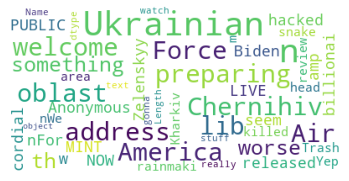

In [23]:
# Generamos nube de palabras del idioma inglés
stopwords_set = set(STOPWORDS)
wordcloud = WordCloud(
    background_color="white",
    stopwords=stopwords_set,
    max_words=400,
    max_font_size=40,
    random_state=42,
).generate(str(df_en["text"]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

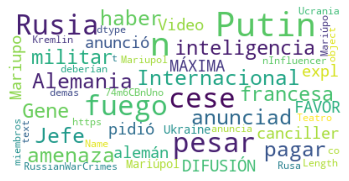

In [24]:
# Hacemos lo mismo con el español
stopwords_es = set(stopwords.words("spanish"))
wordcloud = WordCloud(
    background_color="white",
    stopwords=stopwords_es,
    max_words=400,
    max_font_size=40,
    random_state=42,
).generate(str(df_es["text"]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Si observamos la nube de palabras del inglés podemos ver que las palabras que tienen más fuerzas son: Ucrania, Fuerza, América etc. Podemos ver que se mencionan al presidente de Ucrania y al de Estados Unidos. Este comportamiento es normal debido a que suelen aparecer en los titulares de las noticias. Por otro lado, también aparecen las palabras _Anonymous_ y _Hacked_, las cuales hacen referencia al anuncio de un hackeo de Anonymous al gobierno ruso.

En cambio, si observamos las palabras en español, podemos ver que una de las más usadas es Putin o Rusia. También existen palabras negativas como amenaza o fuego. También vemos la palabra cese, por lo que muchos tweets podrían referirse a la noticia del posible alto el fuego que los informativos propagaron.

Aunque no aparece, otra cuestión interesante sería ver cuántos tweets contienen la palabra "nuclear". Esta palabra se ha usado muchísimo a lo largo de este conflicto, por el peligro y el miedo que supone una III Guerra Mundial. Este tipo de palabras han sido usadas por casi todo el mundo, desde los propios informativos hasta el presidente de Rusia.


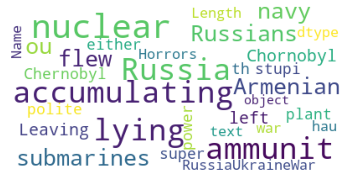

In [25]:
nuclear_tweets = df[df["text"].str.match("^.*nuclear.*$") == True]

stopwords_es = set(stopwords.words("spanish")).union(stopwords.words("english"))
wordcloud = WordCloud(
    background_color="white",
    stopwords=stopwords_es,
    max_words=400,
    max_font_size=40,
    random_state=42,
).generate(str(nuclear_tweets["text"]))

print(wordcloud)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [26]:
nuclear_tweets.shape

(1906, 17)

Observamos que hay muy pocos tweets que hablan de este tema (alrededor de unos 1900). Sin embargo, observando la nube de palabras, podemos ver que el sentimiento es negativo dada la naturaleza del tema. Vemos palabras como mentiras, la noticia del submarino nuclear, horrores etc. Incluso podemos ver insultos como _stupid_ o referencias al accidente nuclear de Chernobyl.


## Preprocesamiento

En este apartado vamos a preparar los datos para crear el modelo. El primer problema que tenemos es que los datos no están etiquetados, al ser datos reales, por lo que no estamos ante un problema de aprendizaje supervisado y no podemos hacer la clasificación. Para solucionar esto y evitar el etiquetado manual, vamos a utilizar una librería llamada `pysentimiento`. Esta librería es un framework con algoritmos del estado del arte en procesamiento del lenguaje natural (NLP), especializada en análisis de sentimientos. Con esta librería se pueden realizar tanto análisis de sentimientos en inglés y en español.

Antes de usar esta librería, tenemos que limpiar los datos. Tenemos que aplicar las siguientes transformaciones:

- Eliminar URLs.
- Eliminar emoticonos.
- Reemplazar varios espacios consecutivos por uno solo.
- Eliminar caracteres de escape con /n o //b etc.
- Eliminar caracteres y otros símbolos extraños, pero manteniendo signos de puntuación.

Para hacer estas transformaciones, vamos a usar las expresiones regulares. Esto lo hacemos para los tweets que estén en inglés y en español.


In [27]:
# Funcion para eliminar URLs
def remove_urls(text):
    text_without_url = re.sub(
        r"(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b",
        "",
        str(text),
        flags=re.MULTILINE,
    )
    return text_without_url


# Funcion para eliminar emojis
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emojis
        "\U0001F300-\U0001F5FF"  # Pictogramas
        "\U0001F680-\U0001F6FF"  # Transporte y simbolos de mapas
        "\U0001F1E0-\U0001F1FF"  # Simbolos de iOS
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)


# Funcion para eliminar espacios consecutivos
def remove_consecutive_spaces(text):
    text_without_consecutive_spaces = re.sub(r"\s+", " ", text)
    return text_without_consecutive_spaces


# Funcion para eliminar otros simbolos
def remove_symbols_en(text):
    text_without_symbols = re.sub(r"[^A-Za-z0-9!?.,;]+", " ", text)
    return text_without_symbols


def remove_symbols_es(text):
    text_without_symbols = re.sub(r"[^A-Za-z0-9áéóúíÁÉÍÓÚñ!¡¿?.,;]+", " ", text)
    return text_without_symbols


# Funcion para eliminar caracteres de escape como //n //b //t etc.
# Para ello usaremos bs4, libreria de python para parsear html
def remove_escape_characters(text):
    text_without_escape_characters = BeautifulSoup(unescape(text), "html.parser")
    return text_without_escape_characters.text

In [28]:
# Preprocesamos los tweets
df_en["text"] = (
    df_en["text"]
    .str.lower()
    .apply(remove_urls)
    .apply(remove_emojis)
    .apply(remove_consecutive_spaces)
    .apply(remove_symbols_en)
    .apply(remove_escape_characters)
)

df_es["text"] = (
    df_es["text"]
    .str.lower()
    .apply(remove_urls)
    .apply(remove_emojis)
    .apply(remove_consecutive_spaces)
    .apply(remove_symbols_es)
    .apply(remove_escape_characters)
)

In [29]:
# Comprobamos si los cambios han sido correctos
df_en["text"].head()
df_es["text"].head()

15     internacional a pesar de haber anunciado la d...
21    a pesar de la amenaza de putin, alemania pagar...
24    jefe de inteligencia militar francesa, el gene...
29    el canciller alemán pidió a putin que le expli...
36    por favor máxima difusión video mariupol antes...
Name: text, dtype: object

A continuación, procedemos al etiquetado automático de los tweets. Para ello creamos un analizador. Este analizador aplica un modelo del estado del arte para realizar análisis de sentimientos. En esta librería se usan como modelos BETO y RoBERTuito en español; para el inglés, BERTweet. La librería también ofrece modelos para clasificar las emociones de un tweet (alegría, tristeza etc.) o discursos de odio.


In [ ]:
analyzer_es = create_analyzer(task="sentiment", lang="es")
analyzer_en = create_analyzer(task="sentiment", lang="en")

In [31]:
print(analyzer_es.predict("Putin es un miserable"))
print(analyzer_es.predict("Ánimo Ucrania"))
print(analyzer_es.predict("Rusia invade Ucrania"))

AnalyzerOutput(output=NEG, probas={NEG: 0.998, NEU: 0.001, POS: 0.001})
AnalyzerOutput(output=POS, probas={POS: 0.862, NEU: 0.128, NEG: 0.010})
AnalyzerOutput(output=NEU, probas={NEU: 0.653, NEG: 0.323, POS: 0.024})


In [32]:
print(analyzer_es.predict("Putin kills ukranians"))
print(analyzer_es.predict("USA enjoys cordially friendly relations with Ukraine"))
print(analyzer_es.predict("Biden sends message to Putin"))

AnalyzerOutput(output=NEG, probas={NEG: 0.972, NEU: 0.018, POS: 0.010})
AnalyzerOutput(output=POS, probas={POS: 0.816, NEU: 0.178, NEG: 0.006})
AnalyzerOutput(output=NEU, probas={NEU: 0.854, NEG: 0.092, POS: 0.055})


Observamos que las predicciones realizadas por el modelo de esta librería son acertadas. A continuación, vamos a etiquetar los sentimientos en ambos dataframe, para dividirlos luego en los conjuntos de entrenamiento y test. En este problema las etiquetas serán: 0, opinión negativa; 1, opinión positiva y 2, opinión neutral.


In [33]:
def predict_en(text):
    sentiment = analyzer_en.predict(text).output

    if sentiment == "NEG":
        label = 0
    elif sentiment == "POS":
        label = 1
    elif sentiment == "NEU":
        label = 2

    return label


def predict_es(text):
    sentiment = analyzer_es.predict(text).output

    if sentiment == "NEG":
        label = 0
    elif sentiment == "POS":
        label = 1
    elif sentiment == "NEU":
        label = 2

    return label

Dado que tenemos una gran cantidad de tweets, vamos a usar solamente 8.800 tweets en el idioma inglés y 8808 en español. Esto lo hacemos porque a la hora de etiquetarlos se pierde mucho tiempo, debido a que el método `apply` es muy lento. Existen otras alternativas como la librería `swifter`, que paraleliza esta función. Sin embargo, en los experimentos que he realizado, no se ha observado una mejora notable en el rendimiento. También se ha probado a usar compresión de listas, pero el resultado es el mismo.


In [35]:
df_en = df_en.reset_index(drop=True).drop_duplicates()
df_es = df_es.reset_index(drop=True).drop_duplicates()

In [42]:
df_es["label"] = df_es["text"].swifter.apply(predict_es)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8808 [00:00<?, ?it/s]

In [43]:
# Guardamos en disco
df_es.to_csv("df_es.csv", index=False)

In [46]:
df_es[["text", "label"]].head()

,text,label
0,internacional a pesar de haber anunciado la d...,2
1,"a pesar de la amenaza de putin, alemania pagar...",2
2,"jefe de inteligencia militar francesa, el gene...",0
3,el canciller alemán pidió a putin que le expli...,0
4,por favor máxima difusión video mariupol antes...,2


In [47]:
df_en_reduce = df_en.iloc[0:8800]
df_en_reduce["label"] = df_en_reduce["text"].swifter.apply(predict_en)
df_en_reduce.to_csv("df_en.csv", index=False)

  0%|          | 0/11 [00:00<?, ?ba/s]

Pandas Apply:   0%|          | 0/8800 [00:00<?, ?it/s]

C:\Users\ajf97\AppData\Local\Temp\ipykernel_21100\298079144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en_reduce['label'] = df_en_reduce['text'].swifter.apply(predict_en)


## Modelado

En este apartado vamos a aplicar los modelos que hemos ido viendo en la asignatura en ambos datasets. En primer lugar, dividimos los conjuntos de entrenamiento y test.


In [2]:
english_tweets = pd.read_csv("df_en.csv")
spanish_tweets = pd.read_csv("df_es.csv")

In [3]:
from sklearn.model_selection import train_test_split

x_train_en, x_test_en, y_train_en, y_test_en = train_test_split(
    english_tweets["text"],
    english_tweets["label"],
    test_size=0.2,
    random_state=42,
    stratify=english_tweets["label"],
)

x_train_es, x_test_es, y_train_es, y_test_es = train_test_split(
    spanish_tweets["text"],
    spanish_tweets["label"],
    test_size=0.2,
    random_state=42,
    stratify=spanish_tweets["label"],
)

In [4]:
# Vemos si existe desbalanceo de clases
from collections import Counter

print(Counter(y_train_en))
print(Counter(y_train_es))

Counter({0: 3385, 2: 3026, 1: 629})
Counter({2: 3781, 0: 3042, 1: 223})


Vamos a tratar este problema con una red feedforward en principio. Posteriormente, probaremos a crear un modelo basado en una red LSTM.


In [5]:
# Importamos las librerías necesarias
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

np.random.seed(7)


num_words = 5000
oov_token = "<UNK>"
pad_type = "post"
trunc_type = "post"

# Tokenizamos los datos de entrenamiento
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(x_train_en)

# Obtenemos el índice de palabras
word_index = tokenizer.word_index

# Codificamos cada tweet en una secuencia de tokens
train_sequences = tokenizer.texts_to_sequences(x_train_en)

# Obtenemos la secuencia máxima
maxlen = max([len(x) for x in train_sequences])

# Hacemos pad de las sentencias
train_padded = pad_sequences(
    train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen
)

test_sequences = tokenizer.texts_to_sequences(x_test_en)
test_padded = pad_sequences(
    test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen
)

y_train_en_cat = tf.keras.utils.to_categorical(y_train_en, num_classes=3)
y_test_en_cat = tf.keras.utils.to_categorical(y_test_en, num_classes=3)

In [75]:
# Creamos el modelo feedforward
model = Sequential()
model.add(Embedding(5000, output_dim=32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(250, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 79, 32)            160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2528)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               632250    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 753       
Total params: 793,003
Trainable params: 793,003
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(train_padded, y_train_en_cat, epochs=3, batch_size=128, verbose=1)

Epoch 1/3
55/55 [==============================] - 1s 6ms/step - loss: 0.3763 - categorical_accuracy: 0.8588
Epoch 2/3
55/55 [==============================] - 0s 6ms/step - loss: 0.1754 - categorical_accuracy: 0.9486
Epoch 3/3
55/55 [==============================] - 0s 5ms/step - loss: 0.0745 - categorical_accuracy: 0.9822


In [72]:
scores = model.evaluate(test_padded, y_test_en_cat, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

55/55 [==============================] - 0s 5ms/step - loss: 0.6961 - categorical_accuracy: 0.7369
Accuracy: 73.69%


In [76]:
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(x_train_es)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train_es)

maxlen = max([len(x) for x in train_sequences])

train_padded = pad_sequences(
    train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen
)

test_sequences = tokenizer.texts_to_sequences(x_test_es)
test_padded = pad_sequences(
    test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen
)

y_train_es_cat = tf.keras.utils.to_categorical(y_train_es, num_classes=3)
y_test_es_cat = tf.keras.utils.to_categorical(y_test_es, num_classes=3)

In [77]:
model.fit(train_padded, y_train_es_cat, epochs=3, batch_size=128, verbose=1)

Epoch 1/3
56/56 [==============================] - 1s 5ms/step - loss: 0.8078 - categorical_accuracy: 0.5670
Epoch 2/3
56/56 [==============================] - 0s 5ms/step - loss: 0.6255 - categorical_accuracy: 0.7408
Epoch 3/3
56/56 [==============================] - 0s 6ms/step - loss: 0.4056 - categorical_accuracy: 0.8611


In [79]:
scores = model.evaluate(test_padded, y_test_es_cat, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

56/56 [==============================] - 0s 6ms/step - loss: 0.7128 - categorical_accuracy: 0.6969
Accuracy: 69.69%


Vemos cómo la red feedforward obtiene resultados aceptables en el conjunto de test en ambos idiomas. También es cierto que existe desbalanceo de clases, pero aun así nos encontramos con una mejor precisión en inglés.


### Redes neuronales LSTM

A continuación, vamos a crear un modelo basado en redes neuronales recurrentes, que son más indicadas para trabajar en problemas NLP. Estos modelos tienen el inconveniente de que se pierde información del contexto si la frase tiene demasiadas palabras. Esto puede ser perjudicial a la hora de clasificar los sentimientos de un tweet. Por este motivo, vamos a usar una red LSTM, que permite almacenar información del contexto.


In [8]:
from keras.layers import SimpleRNN, LSTM

# Creamos el modelo recurrente
model = Sequential()
model.add(Embedding(5000, output_dim=32, input_length=maxlen))
model.add(LSTM(units=250))
model.add(Dense(3, activation="softmax"))
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

In [11]:
history = model.fit(
    train_padded,
    y_train_en_cat,
    epochs=15,
    batch_size=128,
    verbose=1,
    validation_split=0.2,
)

Epoch 1/15
44/44 [==============================] - 2s 39ms/step - loss: 0.9322 - categorical_accuracy: 0.4806 - val_loss: 0.9288 - val_categorical_accuracy: 0.4815
Epoch 2/15
44/44 [==============================] - 2s 38ms/step - loss: 0.9321 - categorical_accuracy: 0.4806 - val_loss: 0.9290 - val_categorical_accuracy: 0.4815
Epoch 3/15
44/44 [==============================] - 2s 38ms/step - loss: 0.9320 - categorical_accuracy: 0.4806 - val_loss: 0.9290 - val_categorical_accuracy: 0.4815
Epoch 4/15
44/44 [==============================] - 2s 38ms/step - loss: 0.9320 - categorical_accuracy: 0.4806 - val_loss: 0.9291 - val_categorical_accuracy: 0.4815
Epoch 5/15
44/44 [==============================] - 2s 38ms/step - loss: 0.9324 - categorical_accuracy: 0.4806 - val_loss: 0.9293 - val_categorical_accuracy: 0.4815
Epoch 6/15
44/44 [==============================] - 2s 38ms/step - loss: 0.9323 - categorical_accuracy: 0.4806 - val_loss: 0.9292 - val_categorical_accuracy: 0.4815
Epoch 7/15

In [12]:
scores = model.evaluate(test_padded, y_test_en_cat, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

55/55 [==============================] - 1s 10ms/step - loss: 0.9310 - categorical_accuracy: 0.4812
Accuracy: 48.12%


Podemos ver que los resultados son peores que en el modelo de red neuronal feedforward. El clasificador no consigue distinguir correctamente ni la mitad de los ejemplos de test. A continuación, vamos a ver cómo se comporta en el caso de los tweets en español.


In [13]:
# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(x_train_es)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(x_train_es)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
train_padded = pad_sequences(
    train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen
)

test_sequences = tokenizer.texts_to_sequences(x_test_es)
test_padded = pad_sequences(
    test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen
)

y_train_es_cat = tf.keras.utils.to_categorical(y_train_es, num_classes=3)
y_test_es_cat = tf.keras.utils.to_categorical(y_test_es, num_classes=3)

In [15]:
model.fit(
    train_padded,
    y_train_es_cat,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/15
45/45 [==============================] - 2s 38ms/step - loss: 0.8000 - categorical_accuracy: 0.5373 - val_loss: 0.8342 - val_categorical_accuracy: 0.5340
Epoch 2/15
45/45 [==============================] - 1s 31ms/step - loss: 0.8003 - categorical_accuracy: 0.5373 - val_loss: 0.8322 - val_categorical_accuracy: 0.5340
Epoch 3/15
45/45 [==============================] - 1s 31ms/step - loss: 0.8002 - categorical_accuracy: 0.5373 - val_loss: 0.8318 - val_categorical_accuracy: 0.5340
Epoch 4/15
45/45 [==============================] - 1s 31ms/step - loss: 0.7997 - categorical_accuracy: 0.5373 - val_loss: 0.8349 - val_categorical_accuracy: 0.5340
Epoch 5/15
45/45 [==============================] - 1s 31ms/step - loss: 0.8005 - categorical_accuracy: 0.5373 - val_loss: 0.8346 - val_categorical_accuracy: 0.5340
Epoch 6/15
45/45 [==============================] - 1s 31ms/step - loss: 0.7992 - categorical_accuracy: 0.5373 - val_loss: 0.8445 - val_categorical_accuracy: 0.5340
Epoch 7/15

In [16]:
scores = model.evaluate(test_padded, y_test_es_cat, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

56/56 [==============================] - 1s 9ms/step - loss: 0.8073 - categorical_accuracy: 0.5363
Accuracy: 53.63%


En este caso, la precisión es mejor que en el idioma inglés, aunque sigue siendo bastante peor que la red feedforward. En este caso, tenemos menos datos que en el conjunto de tweets en inglés.


### Arquitecturas del estado del arte

Finalmente, vamos a probar arquitecturas recientes del estado del arte para ver si podemos mejorar el rendimiento. En el caso de los tweets en inglés, vamos a usar la arquitectura RoBERTa. Esta arquitectura se presentó en 2019 y se basa en mejorar la arquitectura BERT mediante fine-tuning y entrenada con más datos y durante más tiempo. 

La mayoría de los problemas y las arquitecturas que se hacen para resolver problemas NLP están enfocadas a texto en inglés. Sin embargo, también existen varias alternativas para el español, aunque el número de datos que se utilizan para entrenar con respecto al inglés es menor. El número de parámetros en la red también es bastante menor. Algunos de estos modelos son MarIA, arquitectura desarrollada por el equipo del supercomputador de Barcelona y financiada por el gobierno y que está basada en RoBERTa y con datos de la Biblioteca Nacional de España o BERTIN, que es muy reciente (2021) y que también está basada en RoBERTa. También hay otras alternativas más recientes como RigoBERTa, creada por la UAM la cuyos autores indican que superan a las anteriores, pero todavía no se ha publicado el código. Todas arquitecturas se basan en la conocida arquitectura Transformer.

Para este trabajo, vamos a probar las arquitecturas RoBERTa y BETO, utilizando la plataforma Hugging Face, que dispone de muchos modelos de NLP. Como estas arquitecturas son complejas de entrenar debido a la cantidad de recursos que se necesitan, nos limitaremos a evaluar los modelos preentrenados sobre los datos de test, comparando las etiquetas obtenidas con las etiquetas reales.

In [ ]:
# Importamos las librerías necesarias como el tokenizador
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoConfig
from scipy.special import softmax

# Cargamos el modelo y el tokenizador, que se encarga de dividir cada tweet en tokens
roberta = "cardiffnlp/twitter-roberta-base-sentiment-latest"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
config = AutoConfig.from_pretrained(roberta)


In [38]:
# Escogemos un tweet de ejemplo
tweet = x_test_en.iloc[0]

# Creamos los tokens. Esto nos devuelve un diccionario en forma de tensor
encoded_tweet = tokenizer(tweet, return_tensors="pt")
print(encoded_tweet)

{'input_ids': tensor([[    0,    65,  1151,    11,   997,  4024,   342,   179, 18544, 28127,
           131,    37,   351,   326,   912,    23,  1717,   330,  9946,  2753,
           271,   161,   449, 24615,  9657, 23410,    54,    67, 14524,   342,
           179,   579,  1735,    32,    11,     5,   997,   136,  1717,   330,
         23535,     4,  1241, 44736,   342,   179,   605,  9636,   338,  9452,
          1717,   330,  9946,   811,   910, 42472,   605,  9636,   338,  9452,
             2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [34]:
tweet

' one moment in war drove putin insane amp; he won t stop at ukrainewar says khodorkovsky who also discusses putin s options are in the war against ukraine. via youtube putinwarcrimes ukrainian russianwarcrimes'

In [40]:
# Calculamos la predicción del modelo
output = model(**encoded_tweet)

scores = output[0][0].detach().numpy()
scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]

for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) Negative 0.5889
2) Neutral 0.3883
3) Positive 0.0229


A continuación vamos a evaluar sobre todos los datos de test y comparamos con las etiquetas reales.

In [42]:
from sklearn.metrics import accuracy_score


def evaluate_roberta(x_test, y_test):
    predictions = []

    for tweet in x_test:
        encoded_tweet = tokenizer(tweet, return_tensors="pt")
        output = model(**encoded_tweet)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

        ranking = np.argsort(scores)
        ranking = ranking[::-1]

        l = config.id2label[ranking[0]]

        if l == "Negative":
            predictions.append(0)
        elif l == "Neutral":
            predictions.append(2)
        elif l == "Positive":
            predictions.append(1)

    return accuracy_score(y_test, predictions)

In [43]:
evaluate_roberta(x_test_en, y_test_en)

0.8113636363636364

Vemos como la precisión del modelo se ha incrementado bastante con respecto a los modelos LSTM y feed-forward, obteniendo un 0.81 de precisión sobre el conjunto de test.

A continuación vamos a ver cómo se comporta el modelo BETO con los tweets en español. Usamos este modelo porque no existen implementaciones en Hugging Face para la tarea de análisis de sentimientos de los modelos descritos anteriormente. El modelo BETO está basado en BERT y ha sido entrenado con 5k tweets. 

In [47]:
beto = "finiteautomata/beto-sentiment-analysis"
model = AutoModelForSequenceClassification.from_pretrained(beto)
tokenizer = AutoTokenizer.from_pretrained(beto)
config = AutoConfig.from_pretrained(beto)


Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [48]:
# Escogemos un tweet de ejemplo
tweet = x_test_es.iloc[0]

# Creamos los tokens. Esto nos devuelve un diccionario en forma de tensor
encoded_tweet = tokenizer(tweet, return_tensors="pt")
print(encoded_tweet)

{'input_ids': tensor([[    4,  1553,   981,  1048,  1955, 19865,  1255,  1030,  3920, 13289,
          8684,  1040, 12394, 30933,  1040, 12419,  1008,  1500, 14266,  1008,
         18519,  1009,  9524,  1008,  1030,  3920, 13289,  9387, 30935, 18831,
          1089,  4011,  1008,  1089,  4375, 16041,  1042, 23288,  8126, 21125,
          1534,  1089,  4375,  1009,     5]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [49]:
# Calculamos la predicción del modelo
output = model(**encoded_tweet)

scores = output[0][0].detach().numpy()
scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]

for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) NEU 0.9043
2) NEG 0.0933
3) POS 0.0023


Creamos la función para predecir todo el conjunto de test.

In [50]:
def evaluate_beto(x_test, y_test):
    predictions = []

    for tweet in x_test:
        encoded_tweet = tokenizer(tweet, return_tensors="pt")
        output = model(**encoded_tweet)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

        ranking = np.argsort(scores)
        ranking = ranking[::-1]

        l = config.id2label[ranking[0]]

        if l == "NEG":
            predictions.append(0)
        elif l == "NEU":
            predictions.append(2)
        elif l == "POS":
            predictions.append(1)

    return accuracy_score(y_test, predictions)

In [51]:
evaluate_beto(x_test_es, y_test_es)

0.7111237230419978

Observamos que los resultados también mejoran con respecto a las arquitecturas anteriores.

## Conclusiones

A lo largo del trabajo hemos visto como existe una gran diversidad de modelos para resolver problemas de clasificación de sentimientos. En especial, los modelos que mejor funcionan son las redes neuronales, principalmente por su capacidad de trabajar con datos no estructurados como texto. Estos modelos superan a otras técnicas clásicas de aprendizaje automático, obteniendo buenos resultados.

Es necesario realizar un análisis preliminar para ver cómo son los datos y eliminar cualquier tipo de ruido que pudiera afectar al rendimiento. Por ello, hemos hecho un preprocesamiento para eliminar caracteres que no nos hacen falta, tanto en inglés como en español. 

A continuación, hemos ido explorando distintos modelos de red como feedforwad, cuyos resultados no eran muy buenos, pero tampoco desastrosos, obteniendo resultados aceptables. Este tipo de redes se sobreajustan rápidamente y no contienen información del contexto como las redes LSTM. De todas las arquitecturas vistas, las que mejor funcionan son las basadas en transformers. Estas arquitecturas son el estado del arte en NLP, y no solo se tiene en cuenta el contexto, sino que también se tiene en cuenta la posición de las palabras. Además, contiene capas de auto-atención, lo que permite al modelo saber las relaciones existentes entre las palabras. Por todas estas características, se obtienen mejores resultados, algo que hemos podido ver durante el desarrollo. Sin embargo, este tipo de arquitecturas requieren elevados recursos computacionales y bastante tiempo de entrenamiento si queremos entrenar desde cero. La mejor estrategia sería aprovechar los modelos ya entrenados según el idioma con los datos de nuestro problema específico.

Como línea de mejora, se pueden hacer bastantes experimentos. Para empezar, sería interesante aprovechar todos los datos disponibles (cada día más desde que empezó el conflicto). También sería interesante analizar los sentimientos de las personas que viven en Rusia y Ucrania, algo que podemos obtener fácilmente con la columna de localización de los datos. También podríamos hacer un análisis de los países de la OTAN, ya que cada uno tiene una perspectiva diferente del conflicto. Finalmente, con respecto a las arquitecturas, podríamos implementar un modelo ensemble en el caso de tweets en inglés, estrategia que se usa mucho en el estado del arte. En el caso de los tweets en español, podríamos usar modelos basados en las arquitecturas MarIA y RigoBERTa, una vez que el código esté disponible.


### Referencias

* [1]Spain AI, Webinar (AI Tech Talk): Estado del arte en modelos de lenguaje en español, (24 de febrero de 2022). [En línea Video]. Disponible en: https://www.youtube.com/watch?v=m3OcuAf5l9I
* [2]J. D. la Rosa, E. G. Ponferrada, M. Romero, P. Villegas, P. G. de P. Salas, y M. Grandury, «BERTIN: Efficient Pre-Training of a Spanish Language Model using Perplexity Sampling», Procesamiento del Lenguaje Natural, vol. 68, n.º 0, Art. n.º 0, mar. 2022.
* [3]A. Gutiérrez-Fandiño et al., «MarIA: Spanish Language Models», arXiv:2107.07253 [cs], abr. 2022, doi: 10.26342/2022-68-3.
* [4]J. M. Pérez, J. C. Giudici, y F. Luque, «pysentimiento: A Python Toolkit for Sentiment Analysis and SocialNLP tasks», arXiv:2106.09462 [cs], jun. 2021, [En línea]. Disponible en: http://arxiv.org/abs/2106.09462
* [5]Y. Liu et al., «RoBERTa: A Robustly Optimized BERT Pretraining Approach», CoRR, vol. abs/1907.11692, 2019, [En línea]. Disponible en: http://arxiv.org/abs/1907.11692
